# Exploratory Data Analysis for Final Project

In this assignment, your task is to put your new skils to use in the form of an open-ended, exploratory data analysis. In particular, I'm looking for you to demonstrate your ability to use the programmatic tools we've been learning to access data, manipulate it, and visualize some findings while working towards the ultimate goal of developing a final project proposal. Please include the following in your assignment:

  1. A brief summary of the topic (a few sentences)
  2. Access 2 or more datasets, at least one of them using an API (if you are not using any data from an API as part of your project yet, don’t worry about it, and just do this to get some exercise using APIs. You might use it later).
  3. Demonstrate the use of Pandas operations to filter out missing data and/or outliers.
  4. Demonstrate your capacity to use some of the "group-by" operations to produce pivot tables or statistical summaries of your data.
  5. Use Matplotlib or Seaborn to produce 2-3 data visualizations of your data to both explore the data and highlight any notable patterns.
  6. Include a short written analysis of your interpretation of the data.
  7. In a few paragraphs, describe the research question you intend to investigate in your final project, and the plan for the data analysis you intend to perform.

Note that this exercise is intended to help you formulate your project topic. But it is not a binding contract. Your project will most likely evolve over the rest of the semester. So use this as an opportunity to be creative, throw some ideas against the wall and see what sticks. I will release the final project guidelines shortly. In the meantime, dig in!

And as always, please submit this assignment both as a PR on GitHub along with the URL of your PR on bCourses.

# Final Project - Crashes and the Built Environment

My Final Project is looking to see how crash hotspots in Alameda County have changed over the last 10 years. I want to examine the association between crash hotspots and the build environment.

# TIMS Crash Data

Source: https://tims.berkeley.edu/tools/query/index.php?clear=true

- Looking specifically from 1/1/2012 to 12/13/2021 in Alameda County

Codebook Link: https://tims.berkeley.edu/help/SWITRS.php#Codebook

In [69]:
import pandas as pd
import geopandas as gpd
import requests
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
crashes = pd.read_csv("Data/Crashes.csv")

<bound method IndexOpsMixin.value_counts of 0        2021
1        2017
2        2018
3        2019
4        2020
         ... 
72864    2021
72865    2021
72866    2021
72867    2021
72868    2021
Name: ACCIDENT_YEAR, Length: 72869, dtype: int64>

In [19]:
print(crashes.isnull().sum().to_string())

CASE_ID                        0
ACCIDENT_YEAR                  0
PROC_DATE                      0
JURIS                          0
COLLISION_DATE                 0
COLLISION_TIME                 0
OFFICER_ID                    87
REPORTING_DISTRICT         42094
DAY_OF_WEEK                    0
CHP_SHIFT                      0
POPULATION                     0
CNTY_CITY_LOC                  0
SPECIAL_COND                   0
BEAT_TYPE                      0
CHP_BEAT_TYPE                  0
CITY_DIVISION_LAPD         72869
CHP_BEAT_CLASS                 0
BEAT_NUMBER                 1486
PRIMARY_RD                     0
SECONDARY_RD                   0
DISTANCE                       0
DIRECTION                  23524
INTERSECTION                   0
WEATHER_1                      0
WEATHER_2                      0
STATE_HWY_IND                 19
CALTRANS_COUNTY            61727
CALTRANS_DISTRICT          61727
STATE_ROUTE                46373
ROUTE_SUFFIX               61727
POSTMILE_P

# Data Cleaning

The crashes dataset has been geocoded and cleaned by SafeTrec. SafeTrec converted the street address/intersection to geographic coordiantes and although the downloads also include `LATITUDE` and `LONGITUDE`, they were only used to map a small percentage of the records. Geocoded Coordinates is listed in `POINT_X` and `POINT_Y`  fields. 

For the purpose of this assignment, accidents without geocoded located (Point_X and Point_Y) are dropped. 

In [26]:
cleaned_crashes = crashes.dropna(subset = ['POINT_X'])
cleaned_crashes.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,9391207,2021,2022-02-01,112,2021-12-16,1737,403,NaN,4,5,...,0,0,-,-,NaN,NaN,ALAMEDA,SAN LEANDRO,-122.151909,37.692684
1,90418451,2017,2017-03-23,9390,2017-03-18,1450,020357,NaN,6,2,...,0,0,-,-,37.68808,-121.917470,ALAMEDA,PLEASANTON,-121.917473,37.688079
2,90769144,2018,2018-07-16,9375,2018-07-11,1756,019204,NaN,3,2,...,0,0,-,-,37.71484,-122.073830,ALAMEDA,UNINCORPORATED,-122.073822,37.714821
3,90966732,2019,2019-04-12,9375,2019-04-05,350,021939,NaN,5,3,...,0,1,-,-,37.69310,-122.066498,ALAMEDA,UNINCORPORATED,-122.066559,37.693142
4,91164440,2020,2020-01-13,9375,2020-01-09,1105,015147,NaN,4,1,...,0,0,-,-,37.67934,-122.126923,ALAMEDA,UNINCORPORATED,-122.126831,37.679352


In [89]:
## Remap some of the columns based on the Codebook
cleaned_crashes['COLLISION_NAME']=cleaned_crashes['TYPE_OF_COLLISION'].map({"A": "Head-On", "B": "Sideswipe", "C": "Rear End", "D": "Broadside", "E": "Hit Object", "F": "Overturned", "G": "Vehicle/Pedestrian", "H": "Other", "-": "Not Stated"})
cleaned_crashes['COLLISION_NAME'].value_counts()

C:\Users\Melody\AppData\Local\Temp\ipykernel_36332\2288092405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_crashes['COLLISION_NAME']=cleaned_crashes['TYPE_OF_COLLISION'].map({"A": "Head-On", "B": "Sideswipe", "C": "Rear End", "D": "Broadside", "E": "Hit Object", "F": "Overturned", "G": "Vehicle/Pedestrian", "H": "Other", "-": "Not Stated"})


COLLISION_NAME
Rear End              24853
Broadside             15694
Sideswipe              8611
Hit Object             7298
Vehicle/Pedestrian     6008
Head-On                3902
Other                  2537
Overturned             1996
Not Stated              186
Name: count, dtype: int64

## Statistical Summaries

In [64]:
## Total Number of People Injured/Killed
cleaned_crashes[['COLLISION_NAME', 'NUMBER_KILLED', 'NUMBER_INJURED','COUNT_SEVERE_INJ','COUNT_PED_KILLED', 'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED']].groupby(by = "COLLISION_NAME").sum()

,NUMBER_KILLED,NUMBER_INJURED,COUNT_SEVERE_INJ,COUNT_PED_KILLED,COUNT_PED_INJURED,COUNT_BICYCLIST_KILLED,COUNT_BICYCLIST_INJURED
TYPE_OF_COLLISION,,,,,,,
-,2,220,12,0,17,0,49
A,64,5552,387,5,303,2,276
B,56,10802,465,6,216,2,733
C,112,35001,716,9,129,1,293
D,132,22268,759,5,213,7,1878
E,202,8640,861,3,61,3,183
F,39,2309,298,0,6,1,162
G,240,6143,786,238,5745,1,257
H,40,2637,233,0,60,28,1758


In [75]:
cleaned_crashes[['NUMBER_KILLED']].sum()

NUMBER_KILLED    887
dtype: int64

In [79]:
## Average Number of People Injured/Killed per crash type
cleaned_crashes[['COLLISION_NAME', 'NUMBER_KILLED', 'NUMBER_INJURED','COUNT_SEVERE_INJ','COUNT_PED_KILLED', 'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED']].groupby(by = "COLLISION_NAME").mean()

,NUMBER_KILLED,NUMBER_INJURED,COUNT_SEVERE_INJ,COUNT_PED_KILLED,COUNT_PED_INJURED,COUNT_BICYCLIST_KILLED,COUNT_BICYCLIST_INJURED
TYPE_OF_COLLISION,,,,,,,
-,0.010753,1.182796,0.064516,0.000000,0.091398,0.000000,0.263441
A,0.016402,1.422860,0.099180,0.001281,0.077652,0.000513,0.070733
B,0.006503,1.254442,0.054001,0.000697,0.025084,0.000232,0.085124
C,0.004506,1.408321,0.028809,0.000362,0.005191,0.000040,0.011789
D,0.008411,1.418886,0.048362,0.000319,0.013572,0.000446,0.119664
E,0.027679,1.183886,0.117978,0.000411,0.008358,0.000411,0.025075
F,0.019539,1.156814,0.149299,0.000000,0.003006,0.000501,0.081162
G,0.039947,1.022470,0.130826,0.039614,0.956225,0.000166,0.042776
H,0.015767,1.039417,0.091841,0.000000,0.023650,0.011037,0.692944


In [78]:
cleaned_crashes[['ACCIDENT_YEAR', 'TYPE_OF_COLLISION', 'NUMBER_KILLED', 'NUMBER_INJURED','COUNT_SEVERE_INJ','COUNT_PED_KILLED', 'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED']].groupby(by = ['ACCIDENT_YEAR',"TYPE_OF_COLLISION"]).sum()

NUMBER_KILLED  NUMBER_INJURED  \
ACCIDENT_YEAR TYPE_OF_COLLISION                                  
2012          -                              0              18   
              A                              3             457   
              B                              2             894   
              C                              3            3128   
              D                             13            2070   
...                                        ...             ...   
2021          D                             14            2194   
              E                             24             846   
              F                              6             189   
              G                             32             473   
              H                              4             149   

                                 COUNT_SEVERE_INJ  COUNT_PED_KILLED  \
ACCIDENT_YEAR TYPE_OF_COLLISION                                       
2012          -                                 0                 0   
              A                                35                 0   
              B                                22                 0   
              C                                37                 0   
              D                                55                 0   
...                                           ...               ...   
2021          D                               107                 1   
              E                               109                 0   
              F                                39                 0   
              G                                77                30   
              H                                21                 0   

                                 COUNT_PED_INJURED  COUNT_BICYCLIST_KILLED  \
ACCIDENT_YEAR TYPE_OF_COLLISION                                              
2012          -                                  1                       0   
              A                                 25                       0   
              B                                 24                       0   
              C                                 15                       0   
              D                                 20                       0   
...                                            ...                     ...   
2021          D                                 14                       0   
              E                                  4                       0   
              F                                  1                       0   
              G                                422                       1   
              H                                  2                       2   

                                 COUNT_BICYCLIST_INJURED  
ACCIDENT_YEAR TYPE_OF_COLLISION                           
2012          -                                        5  
              A                                       15  
              B                                       64  
              C                                       28  
              D                                      180  
...                                                  ...  
2021          D                                      147  
              E                                       19  
              F                                       14  
              G                                       23  
              H                                       89  

[90 rows x 7 columns]

In [65]:
cleaned_crashes[['COLLISION_SEVERITY', 'NUMBER_KILLED', 'NUMBER_INJURED', 'COUNT_SEVERE_INJ','COUNT_PED_KILLED', 'COUNT_PED_INJURED', 'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED']].groupby(by = "COLLISION_SEVERITY").sum()

,NUMBER_KILLED,NUMBER_INJURED,COUNT_SEVERE_INJ,COUNT_PED_KILLED,COUNT_PED_INJURED,COUNT_BICYCLIST_KILLED,COUNT_BICYCLIST_INJURED
COLLISION_SEVERITY,,,,,,,
1,887,571,194,266,35,45,1
2,0,5764,4323,0,914,0,437
3,0,26680,0,0,2392,0,2765
4,0,60557,0,0,3409,0,2386


In [120]:
## Crosstab of Collision Severity and Collision Type
pd.crosstab(cleaned_crashes['COLLISION_NAME'], cleaned_crashes["COLLISION_SEVERITY"])

COLLISION_SEVERITY,1,2,3,4
COLLISION_NAME,,,,
Broadside,123,674,4208,10689
Head-On,60,303,1145,2394
Hit Object,188,741,3022,3347
Not Stated,2,11,65,108
Other,40,228,1163,1106
Overturned,36,282,1089,589
Rear End,105,619,4467,19662
Sideswipe,51,421,2451,5688
Vehicle/Pedestrian,235,757,2034,2982


## Plot

<Axes: xlabel='COLLISION_NAME'>

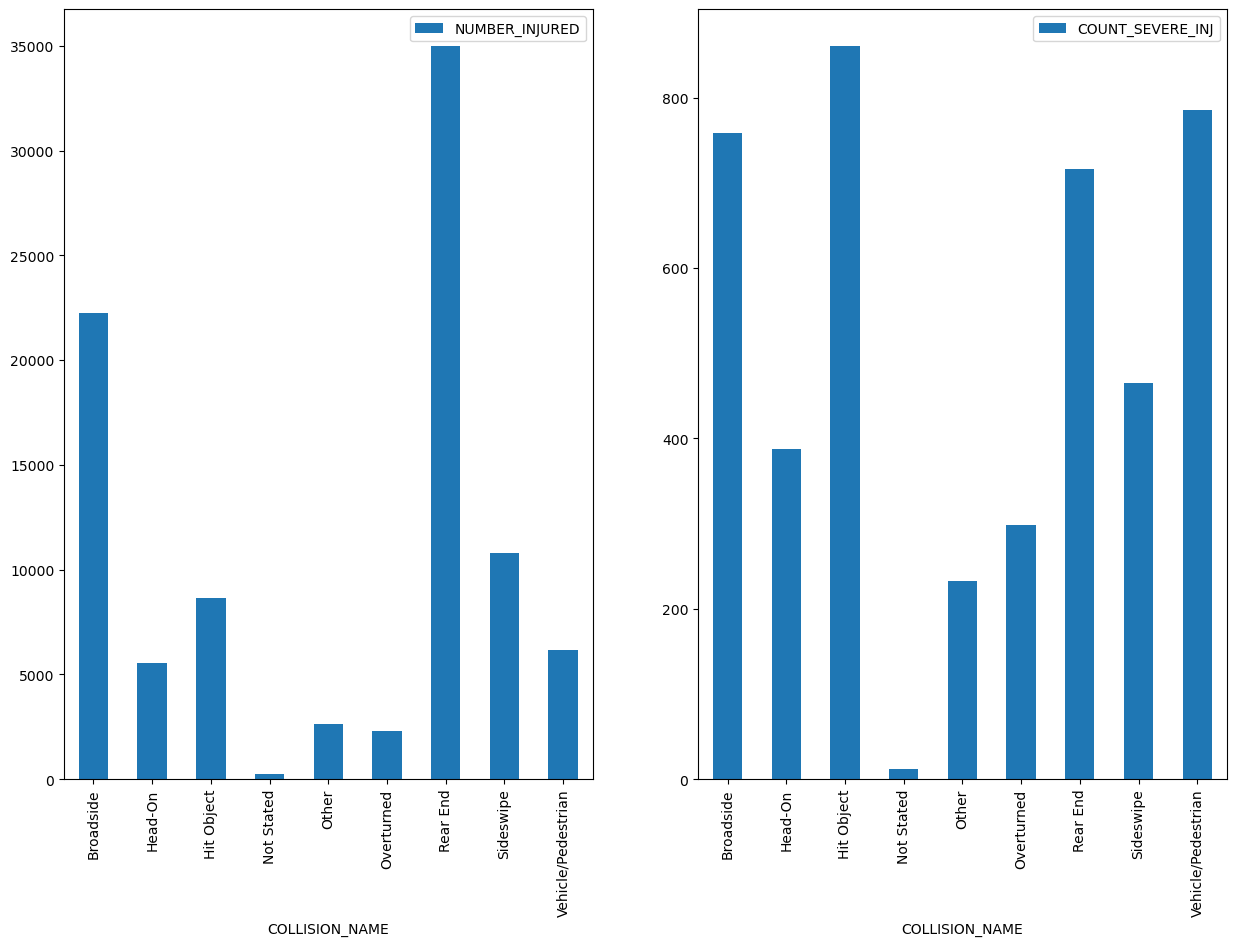

In [93]:
## Plotting Type of Collision and number of people injured and severe injuries  
fig, axes = plt.subplots(ncols = 2, figsize = (15, 10))
cleaned_crashes[['COLLISION_NAME', 'NUMBER_INJURED', ]].groupby(['COLLISION_NAME']).sum().plot(kind='bar', ax = axes[0])

cleaned_crashes[['COLLISION_NAME', 'COUNT_SEVERE_INJ']].groupby(['COLLISION_NAME']).sum().plot(kind='bar', ax = axes[1])

<Axes: xlabel='COLLISION_NAME'>

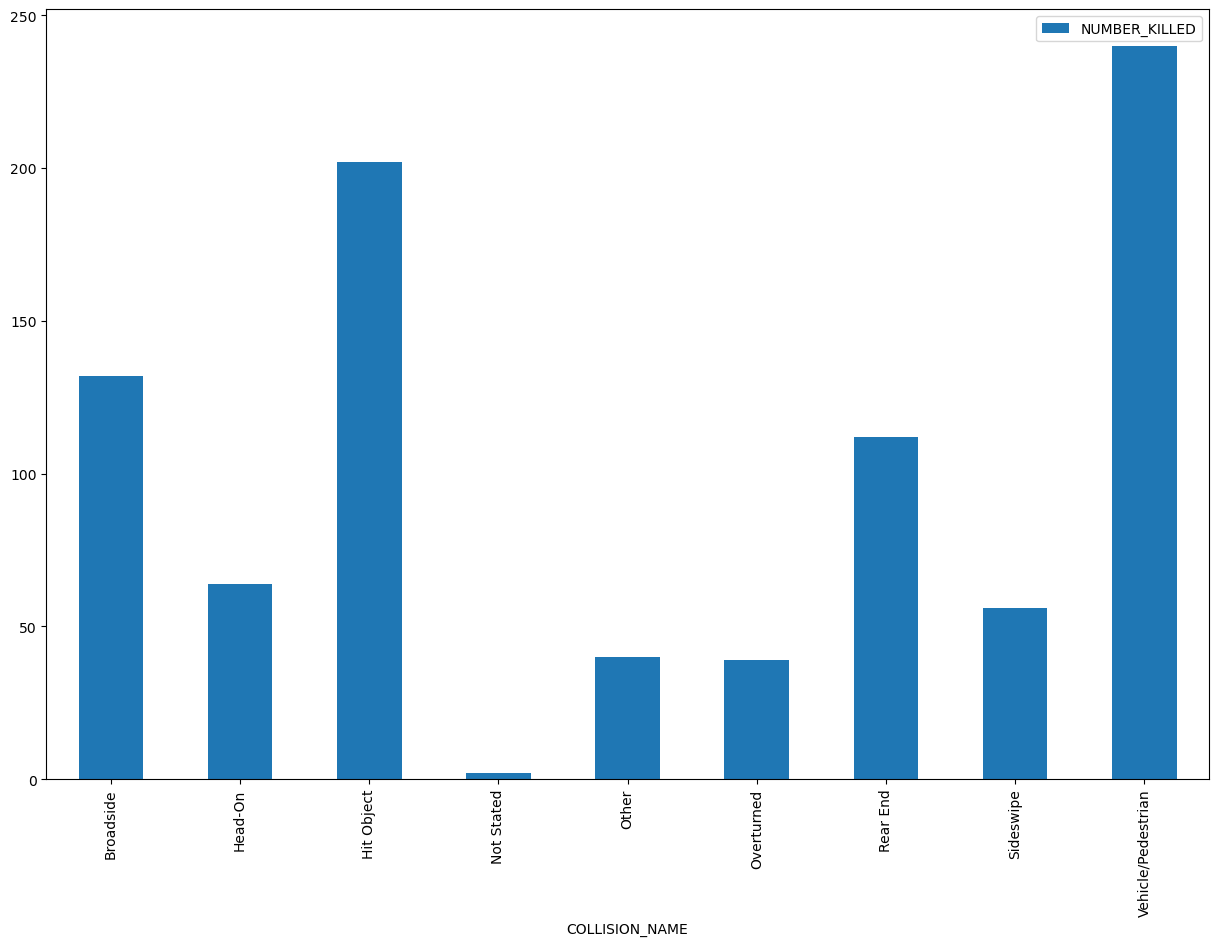

In [94]:
fig, ax = plt.subplots( figsize = (15, 10))
cleaned_crashes[['COLLISION_NAME','NUMBER_KILLED']].groupby(['COLLISION_NAME']).sum().plot(kind='bar', ax = ax)

<Axes: xlabel='None,ACCIDENT_YEAR'>

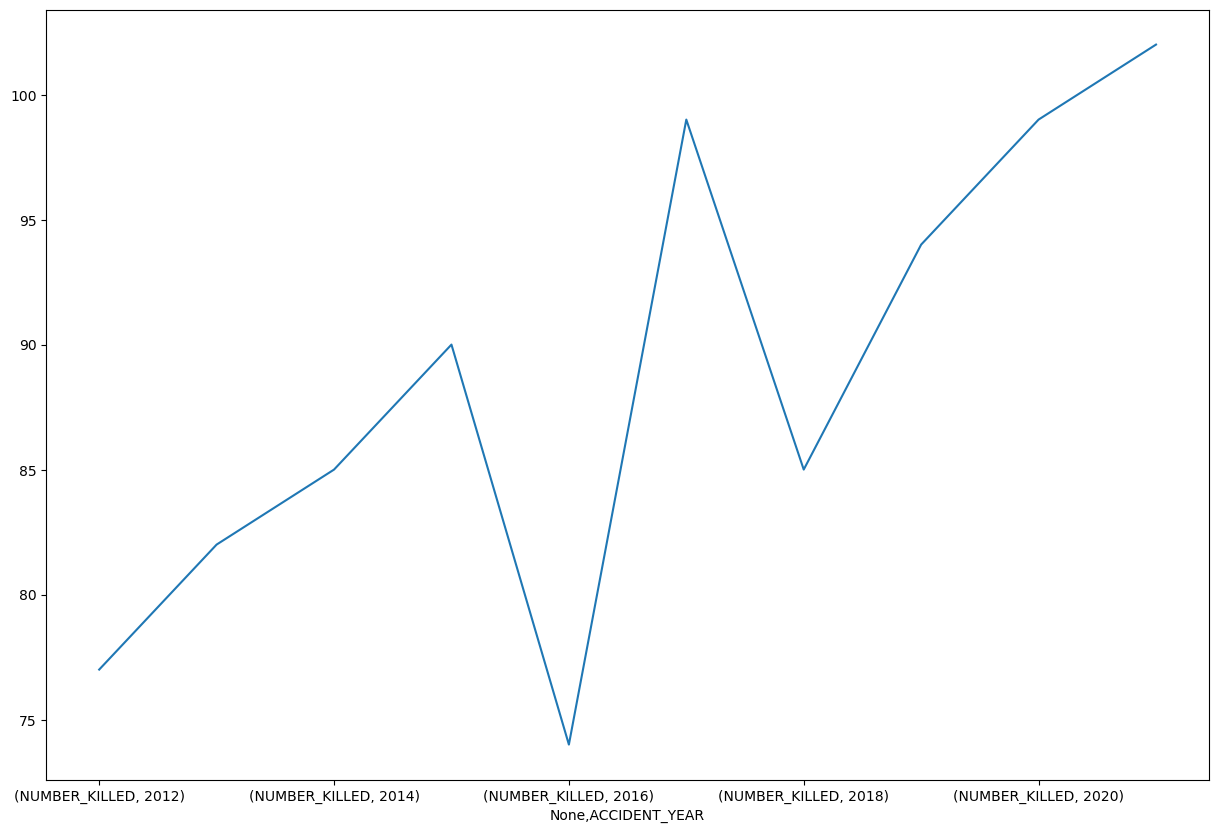

In [100]:
## Plotting Number of people killed by Year
fig, ax = plt.subplots(figsize = (15, 10))
cleaned_crashes[['ACCIDENT_YEAR','NUMBER_KILLED']].groupby(['ACCIDENT_YEAR']).sum().unstack(level=1).plot(kind='line', ax = ax)

<Axes: xlabel='ACCIDENT_YEAR'>

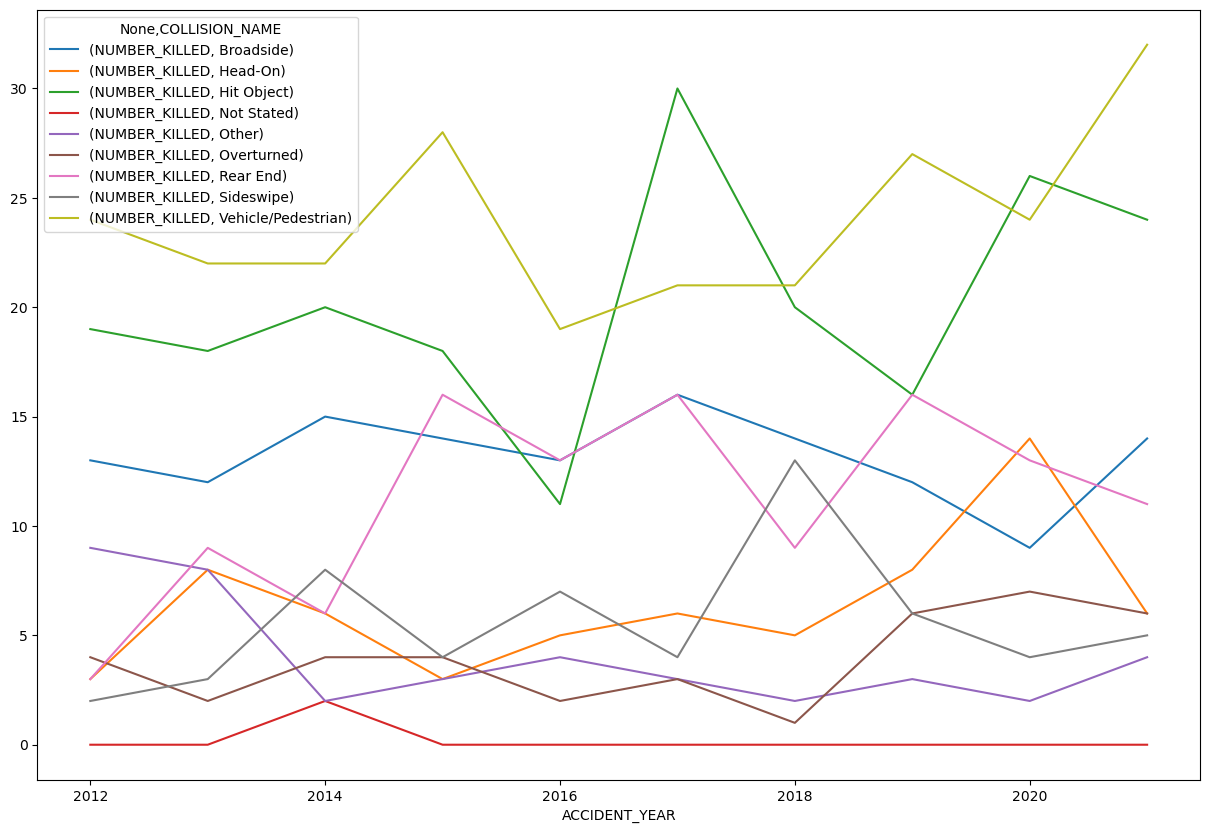

In [99]:
## Plotting Type of Collision and number of people killed by Year
fig, ax = plt.subplots(figsize = (15, 10))
cleaned_crashes[['ACCIDENT_YEAR','COLLISION_NAME','NUMBER_KILLED']].groupby(['ACCIDENT_YEAR','COLLISION_NAME']).sum().unstack(level=1).plot(kind='line', ax = ax)

<Axes: xlabel='None,ACCIDENT_YEAR'>

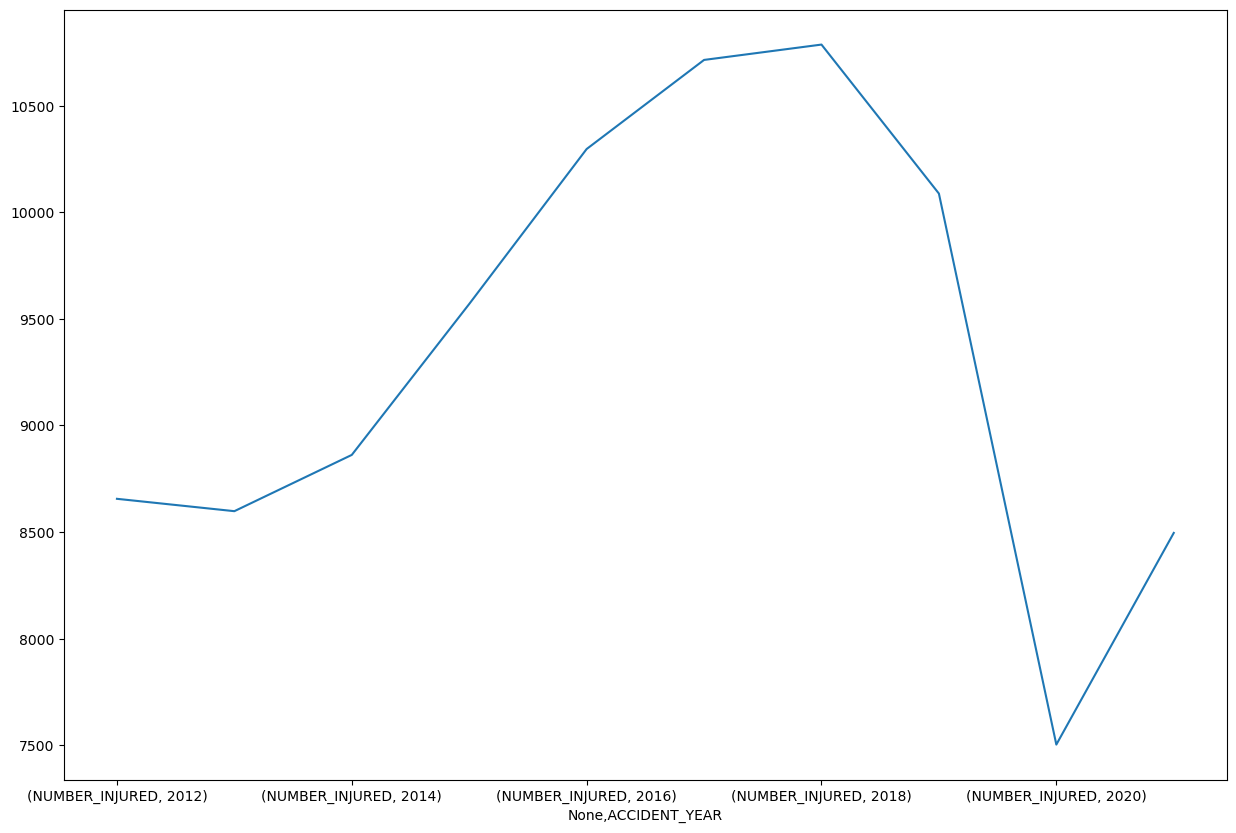

In [101]:
## Plotting number of people injured and killed by Year
fig, ax = plt.subplots(figsize = (15, 10))
cleaned_crashes[['ACCIDENT_YEAR','NUMBER_INJURED']].groupby(['ACCIDENT_YEAR']).sum().unstack(level=1).plot(kind='line', ax = ax)

## Data Interpretation

Different types of collisions results in different severity of injuries. Although one type of collisions may see more injuries, it does not necessarily speak to the severity of the collisions. Broadside and Rear End crashes saw a high number of injured victims, but when looking at fatalities, vehicle and pedestrian crashes saw the highest types. When looking at severe injuries, hit objects collision types saw the highest number. 

Additionally, fatalities trend have not been looking good. While there was a dip in number of fatalities in Alameda County, in recent years, fatalities have been increasing. Surprisingly, fatalities number increased even during the pandemic when there was less vehicle traffic. 

# MTC Regional Data Facilities

Source: https://opendata.mtc.ca.gov/datasets/MTC::regional-bike-facilities/about

**Classification:** 
- **Class I: Off-Street Shared-Use Path -** A bikeway physically separated from motorized vehicular traffic by an open space or barrier. Pedestrians, skaters, wheelchair users, joggers, and other non-motorized users typically use shared-use paths.
- **Class II: Bike Lane -** Portion of the roadway that has been designated by striping, signing and pavement markings for the preferential or exclusive use of bicycles. Some cities and counties also define wide shoulders as bike lanes. Always ride about 4 feet from parked cars to avoid the door zone.
- **Class III: On-Street Bike Route -** Any road or street designated for bicycle travel. These routes are not for the exclusive use of cyclists. Often, routes include residential streets with low auto volumes and speeds.

In [31]:
endpoint_url = "https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/regional_bike_facilities/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
response = requests.get(endpoint_url)
print(response.text[:500])

{"type":"FeatureCollection","properties":{"exceededTransferLimit":true},"features":[{"type":"Feature","id":1,"geometry":{"type":"LineString","coordinates":[[-122.07221896,37.5750360120001],[-122.072017054,37.5748800280001],[-122.071919996,37.5748259970001],[-122.07173904,37.5747249770001],[-122.071396692,37.5745617590001],[-122.07123796,37.5744859710001],[-122.070506017,37.574080021],[-122.070107004,37.5738659690001],[-122.069868026,37.573787022],[-122.069676992,37.5737409920001],[-122.06918405,


In [121]:
data = json.loads(response.text)

In [42]:
lanes = data['features']
d = {
    'class': [b['properties']['class'] for b in lanes],
    'coordinates': [b['geometry']['coordinates'] for b in lanes]
}
b_lanes = pd.DataFrame.from_dict(d)
b_lanes.head()

,class,coordinates
0,3,"[[-122.07221896, 37.5750360120001], [-122.0720..."
1,3,"[[-122.07102499, 37.596901008], [-122.07100243..."
2,3,"[[-122.07102499, 37.596901008], [-122.07100463..."
3,3,"[[-122.069710988, 37.585197986], [-122.0695730..."
4,3,"[[-122.064137963, 37.945220029], [-122.0641372..."


In [122]:
## Realistically, since the file is a line geoJSON, I'll most likely be reading the data through GeoPandas
bike_lanes = gpd.read_file('Data/regional_bike_facilities.shp')
bike_lanes.head()

,class,geometry
0,3,"LINESTRING (-122.07222 37.57504, -122.07202 37..."
1,3,"LINESTRING (-122.07102 37.59690, -122.07100 37..."
2,3,"LINESTRING (-122.07102 37.59690, -122.07100 37..."
3,3,"LINESTRING (-122.06971 37.58520, -122.06957 37..."
4,3,"LINESTRING (-122.06414 37.94522, -122.06414 37..."


In [133]:
## Nothing to clean for Bike Lane Data
bike_lanes.isnull().sum()

class       0
geometry    0
dtype: int64

<Axes: xlabel='class'>

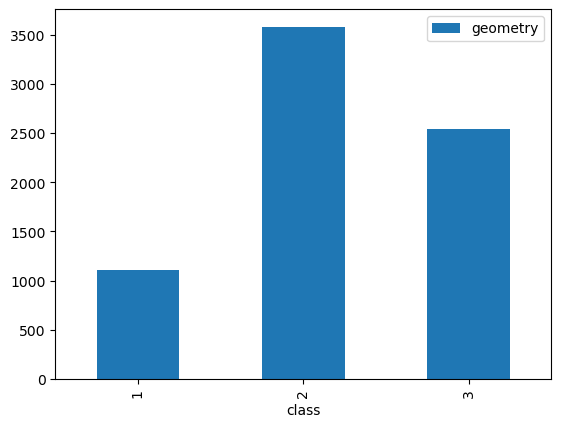

In [130]:
fig, ax = plt.subplots()
bike_lanes.groupby('class').count().plot(kind = 'bar', ax = ax)

Majority of the bike lanes in the MTC region is Class 2 - Bike Lane

# Road Types - FHWA Roadclass Classification from California Road 

Source: https://gisdata-caltrans.opendata.arcgis.com/datasets/cf4982ddf16c4c9ca7242364c94c7ad6_0/about

Data Dictionary:
1. Interstate
2. Other Freeway or Expressway
3. Other Principal Arterial
4. Minor Arterial
5. Major Collector
6. Minor Collector
7. Local

Data was filtered in GIS by county

In [132]:
road = gpd.read_file('Data/CRS - Functional Classification.shp')

In [134]:
## No data cleaning
road.isnull().sum()

EventID       0
RouteID       0
F_System      0
Shape__Len    0
GlobalID      0
geometry      0
dtype: int64

<Axes: xlabel='F_System'>

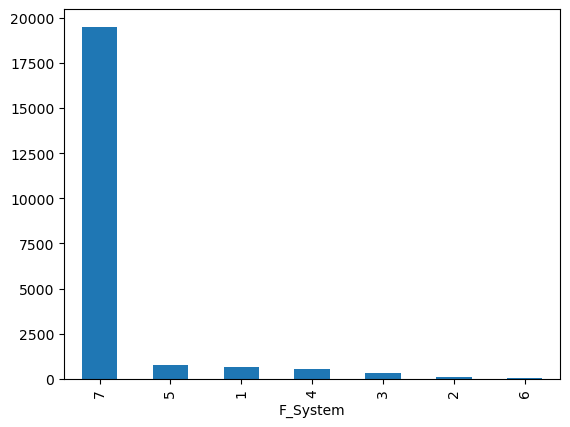

In [138]:
fig, ax = plt.subplots()
road['F_System'].value_counts().plot(kind = 'bar', ax = ax)

Majority of the road types in Alameda County are Road Class 7 - Local Roads

# Final Project Research Question

My research question is how has the built environment impacted safety. I have pulled crash data from the last 10 years and I want to see if there are any trends around certain built environments such as bus stops, bike lanes, type of road class. I will look specifically at the severe and fatal crashes and any crashes that involve pedestrian and bicyclist. My plan is see where hotspots occur with these filtered crashes and then overlay it with infrastructure such as bus stops, bike lanes, and road classes.

My data analysis will include: filtering the crash data and develop a heat map based on the location of the crashes. I will import in the infrastructure data such as bus stops, bike lanes, and road classification and see if crashes can be associated to the infrastructure based on a spatial join. It will be easier to join the crashes with road classification as majority of roads have a classification. Since bike lines and transit stops are more spare, I am thinking of creating a buffer for each of the data points in the dataset and do a spatial join based on the buffer. I am not sure about the buffer distance at the moment, but arbitarily considering 0.2 miles or potentially making the buffer a variable number. 